<a href="https://colab.research.google.com/github/1012357482/proyectogit/blob/Ferrinxon_Camilo_-EDA_clasif_CVRdata_RNA/Ferrinxon_Camilo__EDA_clasif_CVRdata_RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Artificiales Para Predecir Riesgo Cardiovascular

**Autor: Elias Buitrago B.**\
Bogotá, Colombia \
Actualizado: 22 sept 2023 \
_Nota: Código ajustado para su ejecución en Google Colaboratory_\
Verificado con las siguientes versiones: Python 3.10.12, Tensorflow: 2.13.0, Keras: 2.13.1_



In [1]:
# Requirements
# conda install openpyxl
# conda install -c anaconda python-graphviz
# conda install -c anaconda pydot
# pip install xgboost
# pip install shap

## Cargar librerías

In [2]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import process_time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import utils as np_utils


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import graphviz
from sklearn.model_selection import cross_val_score, KFold

In [3]:
import tensorflow
import keras
!lsb_release -a
!python --version
print("Versión de Tensorflow: " + tensorflow.__version__)
print("Versión de Keras: " + keras.__version__)

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy
Python 3.10.12
Versión de Tensorflow: 2.14.0
Versión de Keras: 2.14.0


## Cargar datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# %% # Load data
# 5894 regitros
# 263 registros con datos faltantes de "Clasificación de RCV Global"
# 4 clases de RCV: 0, 1, 2, 3
# Tipos de RCV: Bajo, Intermedio, Alto, Muy Alto
data = pd.read_excel("/content/drive/MyDrive/HSM/pacientes_rcv_limpio.xlsx")
target = data.loc[:, 'Clasificación de RCV Global'].astype(int)
data = data.drop(['Clasificación de RCV Global'], axis=1)

target=pd.Categorical(target).codes

## Conteo de clases

El desbalance de clases es notorio. La clase que representa al riesgo cardiovascular intermedio tiene 40% menos muestras que el riesgo cardiovascular alto. Entretanto, la clase que representa al riesgo cardiovascular bajo tiene 60% menos muestras que el riesgo cardiovascular alto.

In [6]:
import pandas as pd
pd.DataFrame(target).value_counts()

2    1597
1     820
0     583
dtype: int64

## Análisis de Correlación
Teniendo en cuenta que se está tratando con un probemas de clasificación multivariado, se decide iniciar con un análisis de correlación múltiple. Así, será posible descartar variables altamente correlacionadas que puedan afectar el desempeño de los modelos de clasificación.

### Identificar variables correlacionadas al 95%
Se utiliza como criterio una correlación superior al 0.95 y se calcula la correlación para el conjunto de datos. Los resultados indican la ausencia de variables altamente correlacionadas.

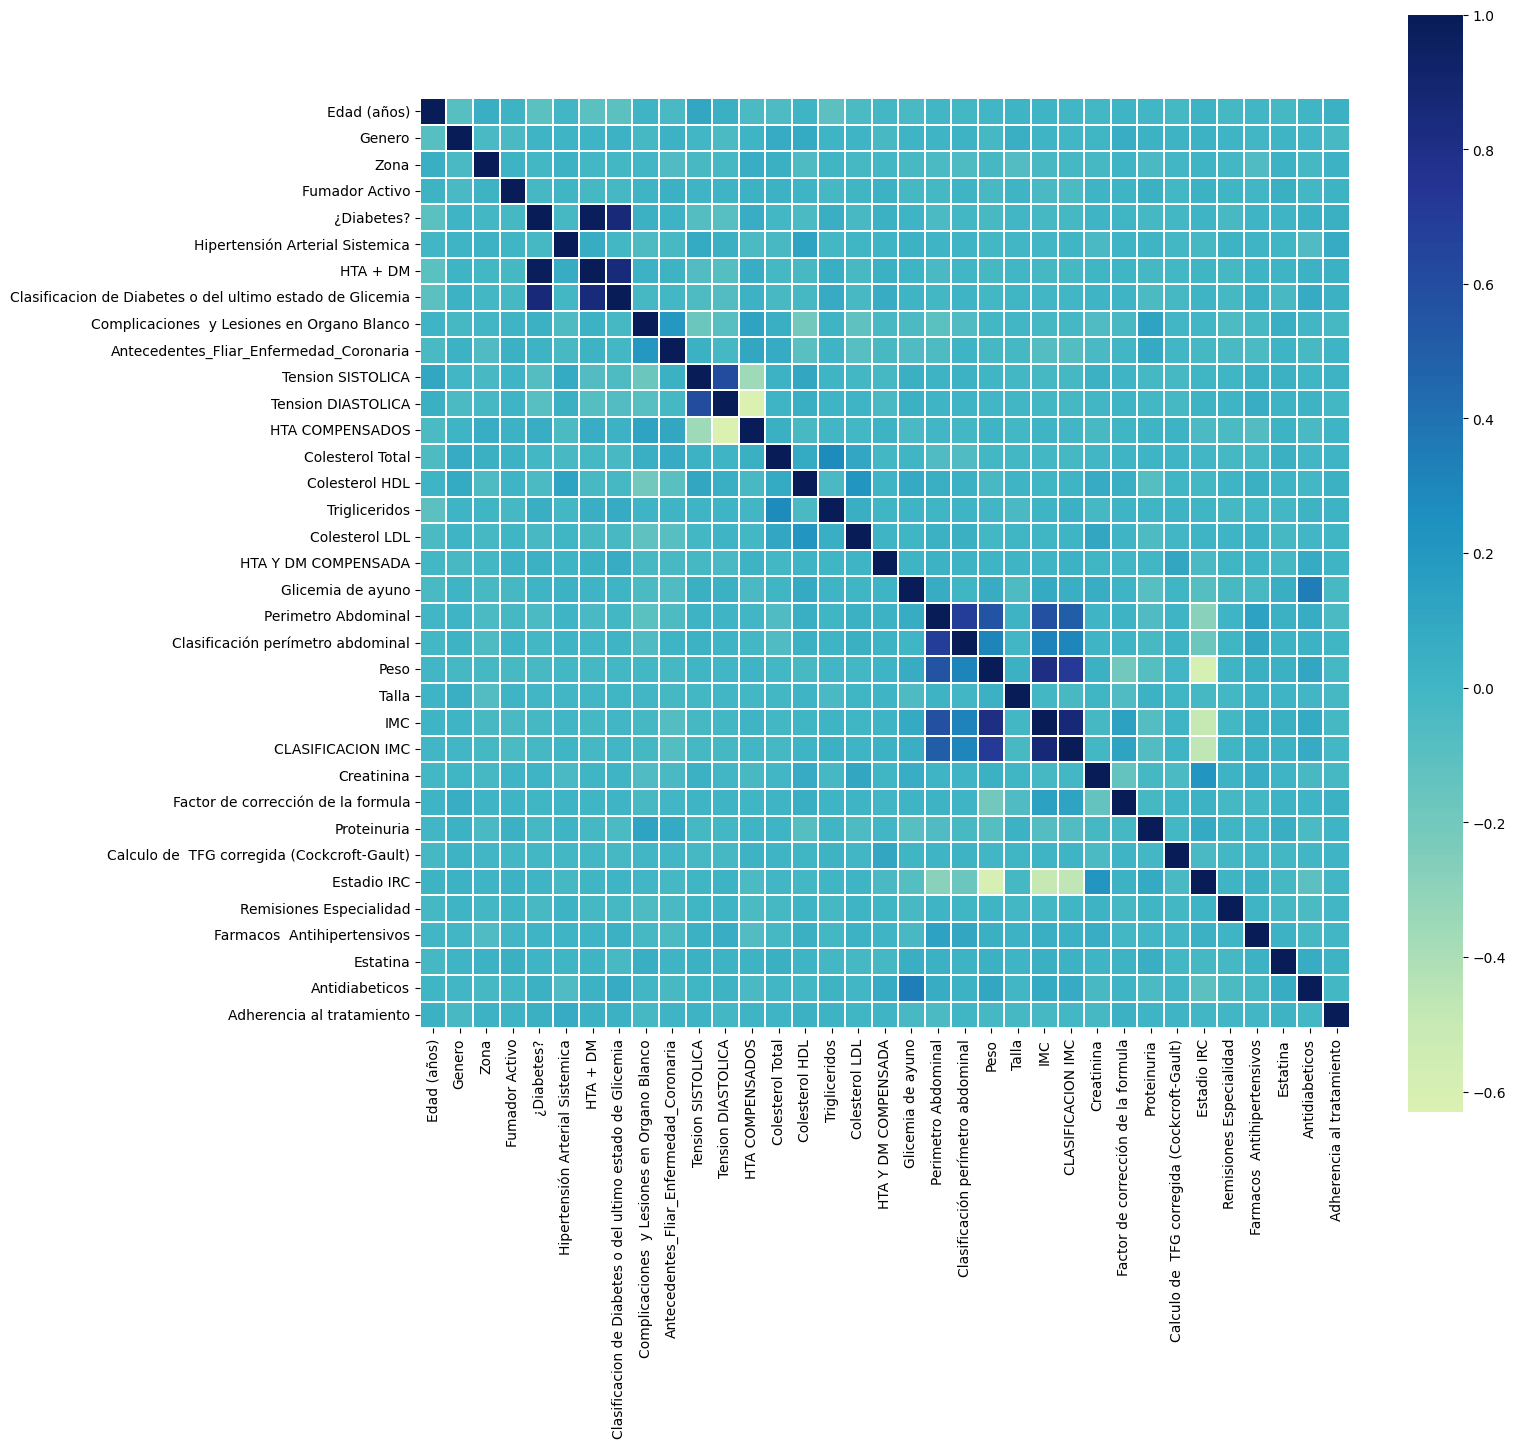

In [7]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.2, annot=False, cbar_kws={"shrink": .95}
                )
    plt.show();

correlation_heatmap(data[np.array(data.columns)])

In [8]:
#Crear la matriz de correlación
cor_matrix = data.corr().abs()

#Sleccionar el triángulo superior de la matriz de correlación
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

#Identificar variables altamente correlacionadas (> 0.95)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['HTA + DM']


No se identifican variables altamente correlacionadas, por lo tanto se decide cambiar el criterio de correlación al 70%.

### Identificar variables correlacionadas al 70%
El gráfico de correlación muestra algunas variables que exhiben correlación fuerte, sin llegar a valores límite (-1, 1). Por lo tanto, se decide excluir las variables correlacionadas al 0.70. Aplicando este nuevo criterio, quedan excluidas las siguientes variables: HTA + DM, Clasificacion de Diabetes o del ultimo estado de Glicemia, IMC, CLASIFICACION IMC. De esta manera se obtiene un nuevo conjunto de datos con 31 variables.

In [9]:
#Crear la matriz de correlación
cor_matrix = data.corr().abs()

#Sleccionar el triángulo superior de la matriz de correlación
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

#Identificar variables altamente correlacionadas (> 0.70)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
print(to_drop)

['HTA + DM', 'Clasificacion de Diabetes o del ultimo estado de Glicemia', 'IMC', 'CLASIFICACION IMC']


## Eliminar variables correlacionadas


In [10]:
data_no_corr = data.drop(data[to_drop], axis=1)
name_vars = data_no_corr.columns
print(data_no_corr.shape)

(3000, 31)


### Reducir conjunto de datos basado en variables importantes halladas en el experimento previo

In [11]:

imp_features_names=np.array(['Edad (años)','Colesterol HDL', 'Genero','Colesterol Total',
                             'Antecedentes_Fliar_Enfermedad_Coronaria',
                             'Tension SISTOLICA','Trigliceridos',
                             'Colesterol LDL'
                           ])
imp_features_idx=np.array([0,12,1,11,7,8,13,14])

imp_features = data_no_corr.columns[imp_features_idx]
data2 = data_no_corr[data_no_corr.columns[imp_features_idx]]
data2.shape
feature_cols=np.array(data2.columns)
feature_cols

array(['Edad (años)', 'Colesterol HDL', 'Genero', 'Colesterol Total',
       'Antecedentes_Fliar_Enfermedad_Coronaria', 'Tension SISTOLICA',
       'Trigliceridos', 'Colesterol LDL'], dtype=object)

## Modelos de clasificación para el conjunto de datos completo

### Particionar datos

In [12]:
# Definir función para particionar el conjunto de datos
def particionar_datos(datos):
    ##transformar datos
    sc = StandardScaler()
    Xsc = sc.fit(datos)
    X = Xsc.transform(datos)
    X.shape
    ##
    X_train, X_test, y_train, y_test = split(X,target,
                                             test_size=0.30,
                                             random_state=42,
                                             stratify=target)
    X_train, X_valid, y_train, y_valid = split(X_train, y_train,
                                               test_size=0.2,
                                               stratify=y_train)
    ##
    print(X_train.shape, X_test.shape, X_valid.shape)
    print(y_train.shape, y_test.shape, y_valid.shape)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [13]:
#Particionar datos
X_train1, X_test1, X_valid1, y_train1, y_test1, y_valid1 = particionar_datos(data2)

# #Transformación de datos requerida para RNA
Y_train1 = np_utils.to_categorical(y_train1)
Y_test1 = np_utils.to_categorical(y_test1)
Y_valid1 = np_utils.to_categorical(y_valid1)

(1680, 8) (900, 8) (420, 8)
(1680,) (900,) (420,)


### Curva ROC


In [14]:
# Curva ROC
# #https://stackabuse.com/understanding-roc-curves-with-python/
def plot_roc_curve(Y_test, Y_pred, titulo):
    auc = roc_auc_score(Y_test, Y_pred)
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,0], Y_pred[:,0])
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    plt.plot(fpr, tpr, color='green', label='ROC RCV bajo')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Postivos')
    plt.title(titulo)
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,1], Y_pred[:,1])
    plt.plot(fpr, tpr, color='darkblue', label='ROC RCV latente')
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,2], Y_pred[:,2])
    plt.plot(fpr, tpr, color='orange', label='ROC RCV alto')
    plt.text(0.7, 0.55, 'AUC: %.2f' % auc, fontdict=font)
    plt.legend()
    plt.show()

### Redes Neuronales

#### Declaración de funciones para RNA

In [64]:
# Definir función para construir la arquitectura del modelo de la RNA
def construrna():
   # Construye modelo RNA
    model = models.Sequential()

    # Capas ocultas, se aumente el número de neurona a 128.
    model.add(layers.Dense(128, activation='relu'))
    # Agregan capas de  dropout para regularización
    # Apagan el 30% de las neurona de forma aleatoria durante el entrenamiento
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Capa de salida con activación softmax para clasificación multiclase
    model.add(layers.Dense(3, activation='softmax'))

    # Compila el modelo
    # Se usa Adam como optimizador en vez del RMSE
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

"""
# Definir función para construir la arquitectura del modelo de la RNA
def construrna():
    #Contruir RNA
    model = models.Sequential()
    model.add(layers.Dense(2, batch_input_shape=(None, 8), activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

# compile the keras (tensorflow) flow graph
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
"""



"\n# Definir función para construir la arquitectura del modelo de la RNA\ndef construrna():\n    #Contruir RNA\n    model = models.Sequential()\n    model.add(layers.Dense(2, batch_input_shape=(None, 8), activation='relu'))\n    model.add(layers.Dense(3, activation='softmax'))\n\n# compile the keras (tensorflow) flow graph\n    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),\n                  loss='binary_crossentropy',\n                  metrics=['accuracy'])\n    return model\n"

 <div style="background-color: yellow;">

## Explicación modificaciones.

*   La función modificadda utiliza capas ocultas con 128 neurona, mientras que  función original utiliza capas ocultas con 2 neuronas, lo que busca aumentar la capacidad del modelo para aprender.
*   Se agregan capas dropout las cuales apagan el 30\% de las neuronas en el proceso de entrenamiento esto para evitar el sobreajuste y mejorar la precisión del modelo.
*   Se elimina el <code> batch_input_shape</code>,p ara no limitar el modelo a a datos de entrada con exactamente 8 características, lo que se busca es que el modelo se adapte automaticamente a las dimensiones de los datos.
*   Se coloca un optimizador de tipo adam
*   Se modifica la función de perdidad <code>loss='categorical_crossentropy</code> que es optima para problemas de clasificación multiclase.
*   Se modifica el optimizador a uno de tipo <code>Adam</code>, ya que este se adapta a los cambios de la capa de aprendizaje en cada parámetro de la red.
*   Estas modificaciones en al arquitectura de la neurona mejoraron la precisión del modelo ya que el AUC de la curva ROC quedo en 0.89%





In [65]:
# Definir función para entrenar la RNA diseñada
def trainrna(model, epo, batch,partial_x_train,partial_y_train,x_val,y_val):
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epo,
                        batch_size=batch,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

In [66]:
# Definir función para la gráficas de pérdidas en entrenamiento y validación
def graf_perdidas_rna(history_rna):
    loss = history_rna.history['loss']
    val_loss = history_rna.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    # Gráfica comparativa: pérdida en entrenamiento
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'g*--', label="Perceptrón 5 capas")
    plt.title('Pérdida en el entrenamiento arquitectura ARN')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc="upper center", fontsize="small")
    plt.legend()
    plt.grid(True)

    # gráfica comparativa: pérdida en validación
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_loss, 'b*--', label="Perceptrón 5 capas")
    plt.title('Pérdida en la validación arquitectura ARN')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc="upper center", fontsize="small")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [67]:
# Métricas de desempeño
def metricas_rna(model_rna, X_test, Y_test):

#     # Exactitud
#     test_loss, test_acc = model.evaluate(X_test, Y_test)# testeo de la red con los de prueba
#     print('\nExactitud evaluación:',test_acc)

    # Version 3
    # predict
    X_pred = model_rna.predict(X_test, batch_size = 32, verbose=1)
    Y_pred = np.argmax(X_pred, axis=1)
    print(Y_pred.shape)

    # Mostrar la precisión, recall, F1-score
    print("\n", metrics.classification_report(Y_test, Y_pred, digits=3))

    return Y_pred

In [68]:
# Matriz de confusión
def matriz_confusion(Y_test,Y_pred,RNA,titulo):
    if RNA == 'si':
        cm = metrics.confusion_matrix(Y_test.argmax(axis=1),
                                      Y_pred.argmax(axis=1))
    else:
        cm = metrics.confusion_matrix(Y_test, Y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['RCV bajo','RCV latente', 'RCV alto']
    plt.title(titulo)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(3):
        for j in range(3):
            plt.text(j,i, str(cm[i][j]))
    return cm

#### Crear modelo RNA, entrenamiento y métricas

In [69]:
# Inicializar el reloj para calcular tiempo de cómputo
t_start = process_time()

# Construir la red neuronal
model_rna1 = construrna()

In [70]:
# Entrenar la red neuronal
history_rna1 = trainrna(model_rna1, 150, 32, X_train1,Y_train1,X_valid1,Y_valid1)

# Tiempo de computo
t_stop = process_time()
tc1 = t_stop-t_start

#Imprimir tiempo de cómputo
print('El tiempo de cómputo con RNA fue: %.2f segundos' % tc1)

El tiempo de cómputo con RNA fue: 31.86 segundos


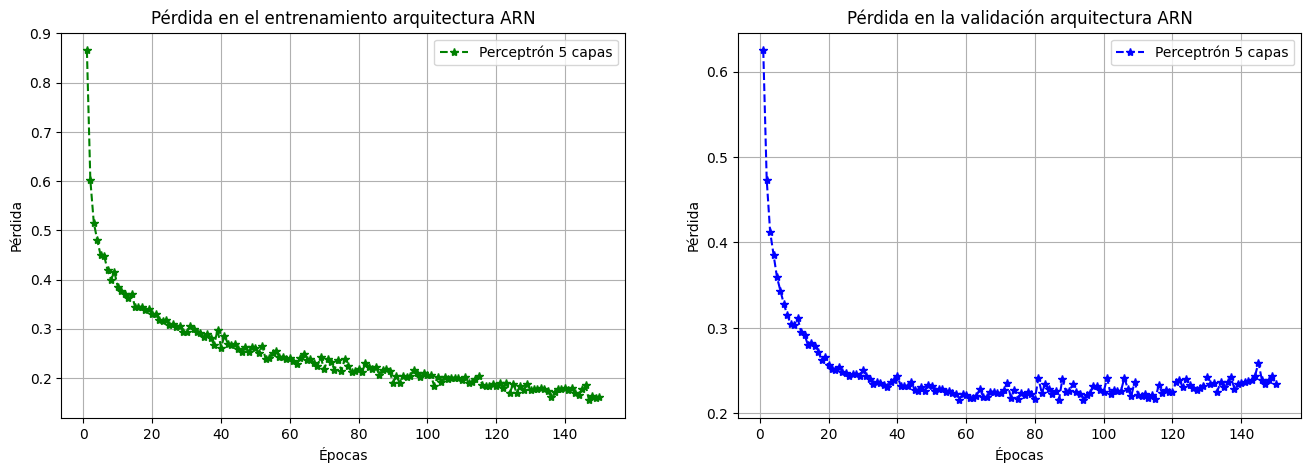

In [71]:
# Gráficas de pérdidas
graf_perdidas_rna(history_rna1)

In [72]:
# Calcular métricas de desempeño
y_pred1 = metricas_rna(model_rna1, X_test1, y_test1)

29/29 [==============================] - 0s 2ms/step
(900,)

               precision    recall  f1-score   support

           0      0.874     0.869     0.871       175
           1      0.797     0.829     0.813       246
           2      0.947     0.929     0.938       479

    accuracy                          0.890       900
   macro avg      0.872     0.876     0.874       900
weighted avg      0.892     0.890     0.891       900



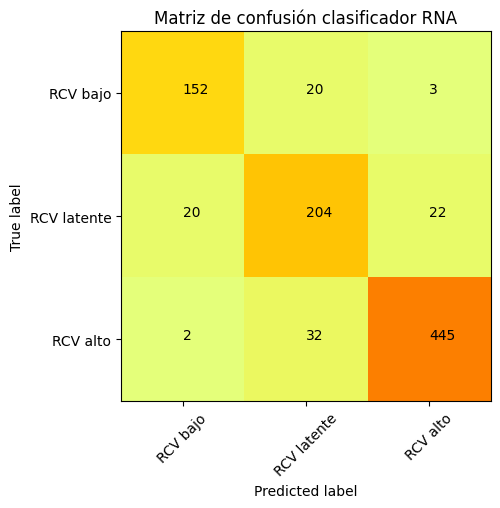

In [73]:
# Matriz de confusión
cm1 = matriz_confusion(y_test1, y_pred1,'no','Matriz de confusión clasificador RNA')

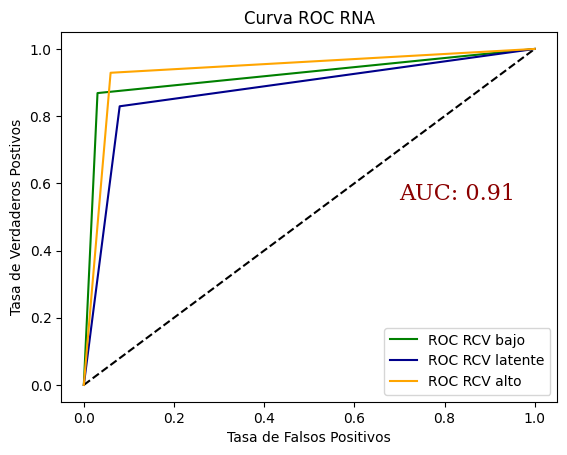

In [74]:
# Curva ROC
Y_pred1 = np_utils.to_categorical(y_pred1)
plot_roc_curve(Y_test1, Y_pred1, 'Curva ROC RNA')

In [75]:
#Guardar modelo
import pickle
pickle.dump(model_rna1, open('RNA_RCV_01.pkl', 'wb'))

# #Cargar modelo almacenado
# model = pickle.load(open('RNA_RCV_01.pkl', 'rb'))
# result_val = model.score(X_valid1, y_valid1)
# result_test = model.score(X_test1, y_test1)
# print(result_val)
# print(result_test)

## Conclusiones


## Explicación modificaciones.

*   La función modificadda utiliza capas ocultas con 128 neurona, mientras que  función original utiliza capas ocultas con 2 neuronas, lo que busca aumentar la capacidad del modelo para aprender.
*   Se agregan capas dropout las cuales apagan el 30\% de las neuronas en el proceso de entrenamiento esto para evitar el sobreajuste y mejorar la precisión del modelo.
*   Se elimina el <code> batch_input_shape</code>,p ara no limitar el modelo a a datos de entrada con exactamente 8 características, lo que se busca es que el modelo se adapte automaticamente a las dimensiones de los datos.
*   Se coloca un optimizador de tipo adam
*   Se modifica la función de perdidad <code>loss='categorical_crossentropy</code> que es optima para problemas de clasificación multiclase.
*   Se modifica el optimizador a uno de tipo <code>Adam</code>, ya que este se adapta a los cambios de la capa de aprendizaje en cada parámetro de la red.
*   Estas modificaciones en al arquitectura de la neurona mejoraron la precisión del modelo ya que el AUC de la curva ROC quedo en 0.89%
